In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import coo_matrix
from lightfm.datasets import fetch_movielens
from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import matplotlib.pyplot as plt

## Read Data

In [2]:
ratings = pd.read_csv('data/ratings.csv')
books = pd.read_csv('data/books.csv')
tags = pd.read_csv('data/tags_cleaned.csv')
book_tags = pd.read_csv('data/book_tags.csv')

In [3]:
display(tags)

,tag_id,tag_name
0,509,19th-century
1,923,20th-century
2,941,21st-century
3,1499,abuse
4,1540,action
...,...,...
329,33114,young-adult
330,33121,young-adult-fantasy
331,33124,young-adult-fiction
332,33165,youth


In [4]:
display(books)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [5]:
display(book_tags)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


In [3]:
mapper = dict(zip(books.goodreads_book_id,books.book_id))
book_tags = book_tags[book_tags.tag_id.isin(tags.tag_id)]
book_tags['id'] = book_tags.goodreads_book_id.apply(lambda x: mapper[x])

In [7]:
display(book_tags)

,goodreads_book_id,tag_id,count,id
1,1,11305,37174,27
4,1,33114,12716,27
5,1,11743,9954,27
6,1,14017,7169,27
10,1,27199,3857,27
...,...,...,...,...
999877,33288638,9886,10,8892
999879,33288638,3358,10,8892
999880,33288638,1679,10,8892
999889,33288638,1659,9,8892


In [8]:
display(ratings)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [4]:
ratings_coo = sparse.coo_matrix((ratings.rating,(ratings.user_id,ratings.book_id)))
feature_ratings  = sparse.coo_matrix(([1]*len(book_tags),(book_tags.id,book_tags.tag_id)))

## model bilding

In [11]:
NUM_THREADS = 6
NUM_COMPONENTS = 60 
NUM_EPOCHS = 10
RANDOM_STATE = 42

In [12]:
auc_scores = []
# Разделение на обучающую и тестовую выборки
train, test = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=RANDOM_STATE)

# Создание модели LightFM
model = LightFM(
    learning_rate=0.05,   # Темп обучения
    loss='warp',          # Тип функции потерь
    no_components=NUM_COMPONENTS,  # Размер латентных факторов
    random_state=RANDOM_STATE
)

# Списки для хранения AUC Score
auc_scores_train = []  # Для тренировки
auc_scores_test = []   # Для теста
patience = 2
min_delta = 1e-3

# Основной цикл обучения
for epoch in range(NUM_EPOCHS):
    print(f'Эпоха {epoch + 1}/{NUM_EPOCHS}')

    # Тренировка модели по одной эпохе с использованием признаков товаров
    model.fit_partial(train, epochs=1, num_threads=NUM_THREADS, item_features=feature_ratings)

    # Вычисляем метрики качества
    auc_value_test = auc_score(model, test, item_features=feature_ratings).mean()  # Передаем признаки товаров в оценку AUC на тестовых данных
    auc_scores_test.append(auc_value_test)

    auc_value_train = auc_score(model, train, item_features=feature_ratings).mean()  # Передаем признаки товаров в оценку AUC на обучающих данных
    auc_scores_train.append(auc_value_train)

    print(f'AUC Test: {auc_value_test:.4f}, AUC Train: {auc_value_train:.4f}')

    # Ранняя остановка обучения, если улучшение минимально
    if epoch >= patience and abs(auc_scores_test[-patience] - auc_scores_test[-1]) <= min_delta:
        print('Раннее завершение обучения')
        break

Эпоха 1/10
AUC Test: 0.9036, AUC Train: 0.9152
Эпоха 2/10
AUC Test: 0.9132, AUC Train: 0.9270
Эпоха 3/10
AUC Test: 0.9171, AUC Train: 0.9322
Эпоха 4/10
AUC Test: 0.9190, AUC Train: 0.9353
Эпоха 5/10
AUC Test: 0.9204, AUC Train: 0.9375
Эпоха 6/10
AUC Test: 0.9213, AUC Train: 0.9393
Раннее завершение обучения


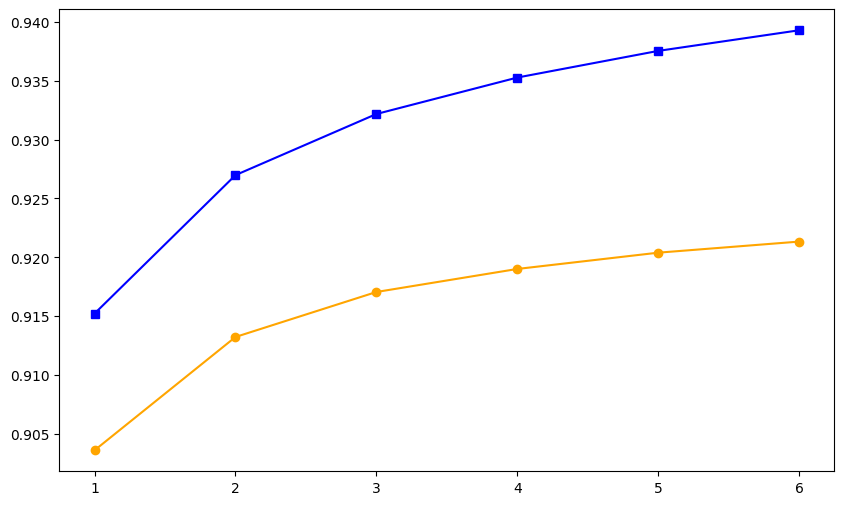

In [16]:
# Построение графиков AUC Score по эпохам
plt.figure(figsize=(10, 6))
# График AUC Score на тренировочном наборе
plt.plot(range(1, 7), auc_scores_train, label="Train", color="blue", marker='s')
# График AUC Score на тестовом наборе
plt.plot(range(1, 7), auc_scores_test, label="Test", color="orange", marker='o')

In [17]:
#Тестируем нашу модель
precision_score = precision_at_k(
    model, #модель
    test, #тестовая выборка
    num_threads=NUM_THREADS, #количество потоков процессора
    k=10, #количество предложений
    item_features=feature_ratings #признаки товаров
).mean() #усредняем результаты
 
recall_score = recall_at_k(
    model, #модель
    test, #тестовая выборка
    num_threads=NUM_THREADS, #количество потоков процессора
    k=10, #количество предложений
    item_features=feature_ratings #признаки товаров
).mean() #усредняем результаты

print(recall_score, precision_score)

0.03945596068544293 0.08541612


In [5]:
import pickle

In [6]:
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [7]:
# Извлекаем эмбеддинги
item_biases, item_embeddings = model.get_item_representations(features=feature_ratings)
item_embeddings = item_embeddings.astype(np.float32)
print(item_biases.shape, item_embeddings.shape)

(10001,) (10001, 60)


In [ ]:
import faiss
from sklearn.preprocessing import normalize
normalized_embeddings = normalize(item_embeddings, norm='l2', axis=1)

In [12]:
d = normalized_embeddings.shape[1]
index = faiss.IndexHNSWFlat(d, 16)
index.hnsw.efConstruction = 100
index.hnsw.efSearch = 32
index.add(normalized_embeddings)

In [13]:
subset_query = normalized_embeddings[:10] 
k = 10                              
distances, indices = index.search(subset_query, k)

for i in range(len(subset_query)):
    print(f"\nОбъект {i}:")
    print("Индексы ближайших соседей:", indices[i])
    print("Расстояния до ближайших соседей:", distances[i])


Объект 0:
Индексы ближайших соседей: [   0 4809  188 3709 4708 7172 7737 2485 3996 4770]
Расстояния до ближайших соседей: [0.         0.9999997  0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.9999998  0.9999998  0.9999998 ]

Объект 1:
Индексы ближайших соседей: [   1   17   20  507 1050   73   12 4279 2880  105]
Расстояния до ближайших соседей: [0.         0.01566111 0.03646423 0.06543326 0.16835143 0.17023042
 0.17248411 0.18528682 0.19061291 0.19243264]

Объект 2:
Индексы ближайших соседей: [   2   23   18   27   25  422   24   21 3753 2101]
Расстояния до ближайших соседей: [0.         0.00590564 0.02689983 0.02746099 0.02785431 0.05045381
 0.0547172  0.09952808 0.12275138 0.13423018]

Объект 3:
Индексы ближайших соседей: [   3   49   52 1803  992  220 2394  210   56 3095]
Расстояния до ближайших соседей: [0.         0.06721039 0.08665383 0.09236927 0.11343388 0.11844317
 0.1362311  0.19523366 0.20674501 0.20798877]

Объект 4:
Индексы ближайших соседей: [   4  131  595   

In [14]:
def nearest_books_faiss(book_id, index, n=10):
    """
    Вспомогательная функция для поиска ближайших книг в индексе FAISS.
    
    :param book_id: ID книги, для которой ищем ближайших соседей
    :param index: Индекс, созданный с помощью библиотеки FAISS
    :param n: Количество ближайших соседей (по умолчанию 10)
    :return: кортеж (distance, indices), где:
            - distance:]` список расстояний до ближайших соседей,
            - indices: список индексов ближайших соседей
    """
    # Формируем запрос (берём эмбеддинг нужной книги)
    query_vector = normalized_embeddings[book_id][None, :]  # добавляем дополнительную ось для соответствия форме ввода

    # Выполняем поиск ближайших соседей
    distances, indices = index.search(query_vector, n)

    # Возвращаем кортеж (расстояния, индексы)
    return distances.squeeze(), indices.squeeze()

In [15]:
# Найдем ближайших соседей для первой книги
result_distances, result_indices = nearest_books_faiss(846, index, n=10)

print("Индексы ближайших книг:", result_indices)
print("Расстояния до ближайших книг:", result_distances)

Индексы ближайших книг: [846  14  55  48 809  13 903 529 271 173]
Расстояния до ближайших книг: [0.         0.07413946 0.08264498 0.12527263 0.14403774 0.14686225
 0.18738434 0.19574244 0.20128118 0.21605755]


In [16]:
books[books.book_id.isin(result_indices)][['authors', 'title']]

,authors,title
12,"George Orwell, Erich Fromm, Celâl Üster",1984
13,George Orwell,Animal Farm
47,Ray Bradbury,Fahrenheit 451
54,Aldous Huxley,Brave New World
172,Anthony Burgess,A Clockwork Orange
270,Daniel Keyes,Flowers for Algernon
528,"Jonathan Swift, Robert DeMaria Jr.",Gulliver's Travels
808,"Aldous Huxley, Christopher Hitchens",Brave New World / Brave New World Revisited
845,"George Orwell, Christopher Hitchens",Animal Farm / 1984
902,Ayn Rand,Anthem


In [17]:
with open('item_embeddings.pkl', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)